Text Classification Using CNN, LSTM and Pre-trained Glove Word Embeddings.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [3]:
# vocab_size = 5000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [4]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(articles)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(articles)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_size = int(len(articles) * training_portion)
training_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

validation_sequences = padded[train_size:]
validation_labels = labels[train_size:]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [6]:
print(training_sequences.shape)
print(validation_sequences.shape)
print(training_label_seq.shape)
print(validation_label_seq.shape)

(1780, 200)
(445, 200)
(1780, 1)
(445, 1)


In [7]:
print(vocab_size)
print(word_index['i'])

29698
4624


First, we need to load the entire GloVe word embedding file into memory as a dictionary of word to embedding array. Next, we need to create a matrix of one embedding for each word in the training dataset.

In [8]:
embeddings_index = {};
with open('glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

The result is a matrix of weights only for words we will see during training.

In [9]:
print(len(embeddings_matrix))

29699


Now we can define our model, fit, and evaluate it as before.

The key difference is that the embedding layer can be seeded with the GloVe word embedding weights.

We do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2969900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 3,035,378
Trainable params: 65,478
Non-trainable params: 2,969,900
_______________________________________

In [13]:
num_epochs = 10
history = model.fit(training_sequences, training_label_seq, epochs=num_epochs, validation_data=(validation_sequences, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 5s - loss: 1.0414 - accuracy: 0.6427 - val_loss: 0.2790 - val_accuracy: 0.9326
Epoch 2/10
1780/1780 - 2s - loss: 0.3000 - accuracy: 0.9056 - val_loss: 0.2106 - val_accuracy: 0.9483
Epoch 3/10
1780/1780 - 2s - loss: 0.1706 - accuracy: 0.9478 - val_loss: 0.2265 - val_accuracy: 0.9191
Epoch 4/10
1780/1780 - 2s - loss: 0.1728 - accuracy: 0.9438 - val_loss: 0.1207 - val_accuracy: 0.9640
Epoch 5/10
1780/1780 - 2s - loss: 0.1227 - accuracy: 0.9657 - val_loss: 0.1596 - val_accuracy: 0.9506
Epoch 6/10
1780/1780 - 2s - loss: 0.1201 - accuracy: 0.9624 - val_loss: 0.1224 - val_accuracy: 0.9640
Epoch 7/10
1780/1780 - 2s - loss: 0.0989 - accuracy: 0.9697 - val_loss: 0.0992 - val_accuracy: 0.9640
Epoch 8/10
1780/1780 - 2s - loss: 0.1117 - accuracy: 0.9663 - val_loss: 0.1191 - val_accuracy: 0.9596
Epoch 9/10
1780/1780 - 2s - loss: 0.1620 - accuracy: 0.9433 - val_loss: 0.1314 - val_accuracy: 0.9438
Epoch 10/10
1780/1780 - 2s - loss: 

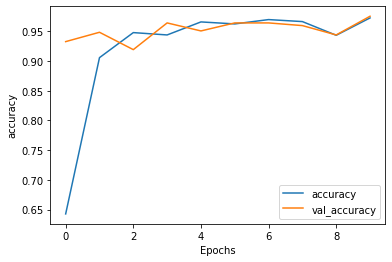

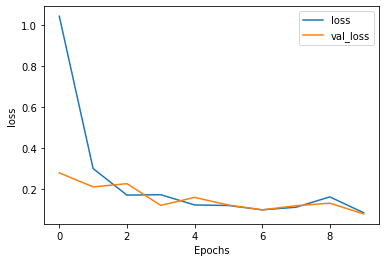

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss");